In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import data

warnings.simplefilter(action='ignore', category=FutureWarning)

# Read & Process

## Read equities & cryptocurrencies data

In [2]:
df_equity = data.read_excel_sheets()
df_equity['OpenTime'] = pd.to_datetime(df_equity['OpenTime'])
df_equity = df_equity.set_index('OpenTime') 

list_equity = df_equity.Symbol.unique().tolist()
print(f"\nEquity:\n{list_equity}")

crypto = 'data_crypto.xlsx'
df_crypto = (
    pd.read_excel(crypto)
    .drop(columns=['Unnamed: 0'])
)

df_crypto['OpenTime'] = pd.to_datetime(df_crypto['OpenTime'])
df_crypto = df_crypto.set_index('OpenTime') 

list_crypto = df_crypto.Symbol.unique().tolist()
print(f"\nCrypto:\n{list_crypto}")

AAPL
MSFT
NVDA
AMZN
META
GOOGL
BRK.B
GOOG
AVGO
TSLA
SPY_ETF
DAXEX_ETF
CAC40_ETF
NKY225_ETF
DJIA_ETF
EQQQ_ETF
FTSE_ETF

Equity:
['NKY225_ETF', 'AAPL', 'AMZN', 'AVGO', 'BRK.B', 'DJIA_ETF', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY_ETF', 'TSLA', 'DAXEX_ETF', 'CAC40_ETF', 'EQQQ_ETF', 'FTSE_ETF']

Crypto:
['ADAUSDT', 'AVAXUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'ETHUSDT', 'SOLUSDT', 'TRXUSDT', 'USDCUSDT', 'XRPUSDT']


# Pair Trading Example

## Prepare the pair trading series

In [3]:
ticker_eqt = 'DJIA_ETF'
ticker_cpy = 'BNBUSDT'

price_eqt = df_equity[df_equity['Symbol']==ticker_eqt]['Close'].rename(ticker_eqt)
t00 = price_eqt.index[0]

price_cpy = df_crypto[df_crypto['Symbol']==ticker_cpy]['Close'].rename(ticker_cpy)
t10 = price_cpy.index[0]

merged = pd.concat([price_eqt, price_cpy], axis=1)

if t00 > t10:
    t0 = t00
else:
    t0 = t10

merged = merged.loc[t0:].dropna()
merged

,DJIA_ETF,BNBUSDT
OpenTime,,
2024-10-14 12:30:00,427.88,590.50
2024-10-14 12:35:00,427.66,590.10
2024-10-14 12:40:00,427.92,589.30
2024-10-14 12:45:00,428.53,588.70
2024-10-14 12:50:00,428.00,588.30
...,...,...
2025-01-06 18:45:00,426.26,738.47
2025-01-06 18:50:00,426.57,738.72
2025-01-06 18:55:00,427.13,737.95


- Helper functions to create a Pandas datafram with 2 different series

In [4]:
def process_pairs_series(seriesX, seriesY, dfX, dfY):

    priceX = dfX[dfX['Symbol']==seriesX]['Close'].rename(seriesX)
    t00 = priceX.index[0]
    
    priceY = dfY[dfY['Symbol']==seriesY]['Close'].rename(seriesY)
    t10 = priceY.index[0]

    merged = pd.concat([priceX, priceY], axis=1)
    if t00 > t10:
        t0 = t00
    else:
        t0 = t10
    
    return merged.loc[t0:].dropna()

In [9]:
seriesX = 'NVDA'
seriesY = 'BNBUSDT'

price_pairs1 = process_pairs_series(seriesX, seriesY, df_equity, df_crypto)
price_pairs1

,NVDA,BNBUSDT
OpenTime,,
2024-10-14 12:30:00,137.9800,590.50
2024-10-14 12:35:00,138.0400,590.10
2024-10-14 12:40:00,137.6000,589.30
2024-10-14 12:45:00,138.1000,588.70
2024-10-14 12:50:00,138.6400,588.30
...,...,...
2025-01-06 18:35:00,149.9900,740.84
2025-01-06 18:40:00,149.8101,740.39
2025-01-06 18:45:00,148.8970,738.47


In [10]:
seriesX = 'DJIA_ETF'
seriesY = 'AVAXUSDT'

price_pairs2 = process_pairs_series(seriesX, seriesY, df_equity, df_crypto)
price_pairs2

,DJIA_ETF,AVAXUSDT
OpenTime,,
2024-10-14 12:30:00,427.88,29.37
2024-10-14 12:35:00,427.66,29.38
2024-10-14 12:40:00,427.92,29.32
2024-10-14 12:45:00,428.53,29.22
2024-10-14 12:50:00,428.00,29.13
...,...,...
2025-01-06 18:45:00,426.26,44.01
2025-01-06 18:50:00,426.57,43.99
2025-01-06 18:55:00,427.13,43.99


## Test for Augmented Dickey-Fuller (ADF), Cointegration & Correlation

In [29]:
def run_cointegration_test(price_pairs, print_stats=False, plotting=False, std=2):

    priceX = price_pairs.iloc[:, 0]
    priceY = price_pairs.iloc[:, 1]
    
    tickerX = priceX.name
    tickerY = priceY.name

    model = sm.OLS(priceY, sm.add_constant(priceX)).fit()
    beta = model.params.iloc[1] #hedge ratio
    spread = priceY - beta * priceX
    # residuals = model.resid

    # executed ADF test and Correlation
    adf_result = adfuller(spread)
    correlation = priceX.corr(priceY)

    if print_stats:
        print(f"Pairs: {tickerX} & {tickerY}")
        print(f"Correlation: {correlation:.3f}")
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        if adf_result[1] < 0.05:
            print(f"p-value: {adf_result[1]:.3f} (Spread is stationary)")
        else:
            print(f"p-value: {adf_result[1]:.3f} (Spread is non-stationary)")

    if plotting:
        # spreads computes
        spread_mean = spread.mean()
        spread_std = spread.std()
        z_score = (spread - spread_mean) / spread_std

        # Create a 1x3 subplot layout
        fig, axes = plt.subplots(1, 3, figsize=(21, 4))  # 1 row, 3 columns
        
        # Plot 1: Spread and Trading Thresholds
        axes[0].plot(spread, label='Spread')
        axes[0].axhline(spread_mean, color='red', linestyle='--', label='Mean')
        axes[0].axhline(spread_mean + std * spread_std, color='green', linestyle='--', label='Upper Threshold')
        axes[0].axhline(spread_mean - std * spread_std, color='green', linestyle='--', label='Lower Threshold')
        axes[0].set_title('Spread and Trading Thresholds')
        axes[0].legend()
        
        # Plot 2: Z-Score of Spread
        axes[1].plot(z_score, label='Z-Score')
        axes[1].axhline(std, color='green', linestyle='--', label='Upper Threshold')
        axes[1].axhline(-std, color='green', linestyle='--', label='Lower Threshold')
        axes[1].axhline(0, color='red', linestyle='--', label='Mean')
        axes[1].set_title('Z-Score of Spread')
        axes[1].legend()
        
        # Plot 3: Normalized Prices
        price_normalized = price_pairs / price_pairs.iloc[0]
        axes[2].plot(price_normalized[tickerX], label=f'{tickerX} (Normalized)', linestyle='-')
        axes[2].plot(price_normalized[tickerY], label=f'{tickerY} (Normalized)', linestyle='--')
        axes[2].set_title(f'Price Correlation of {tickerX} and {tickerY} (Normalized)')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Normalized Price')
        axes[2].legend()
        axes[2].grid(True)
        
        # Adjust layout for better display
        plt.tight_layout()
        plt.show()

    return spread, adf_result, correlation


Pairs: NVDA & BNBUSDT
Correlation: -0.139
ADF Statistic: -1.0149
p-value: 0.748 (Spread is non-stationary)


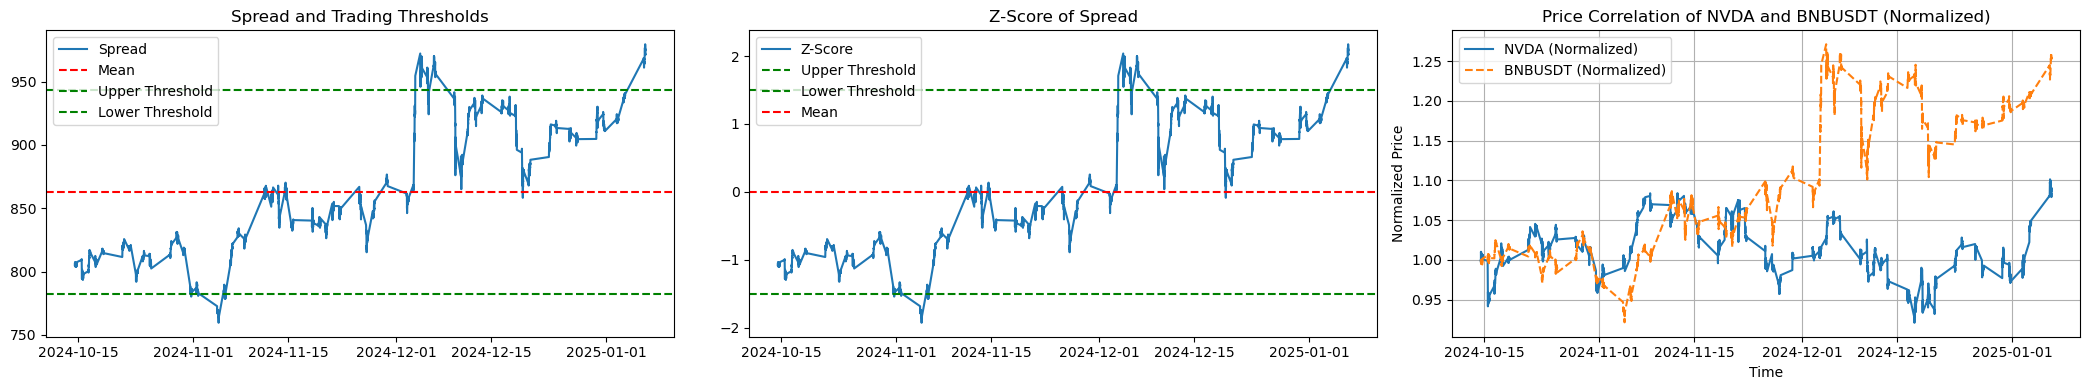

In [30]:
spread, adf_result, correlation = run_cointegration_test(price_pairs1, print_stats=True, plotting=True, std=1.5)

Pairs: DJIA_ETF & AVAXUSDT
Correlation: 0.702
ADF Statistic: -1.5913
p-value: 0.488 (Spread is non-stationary)


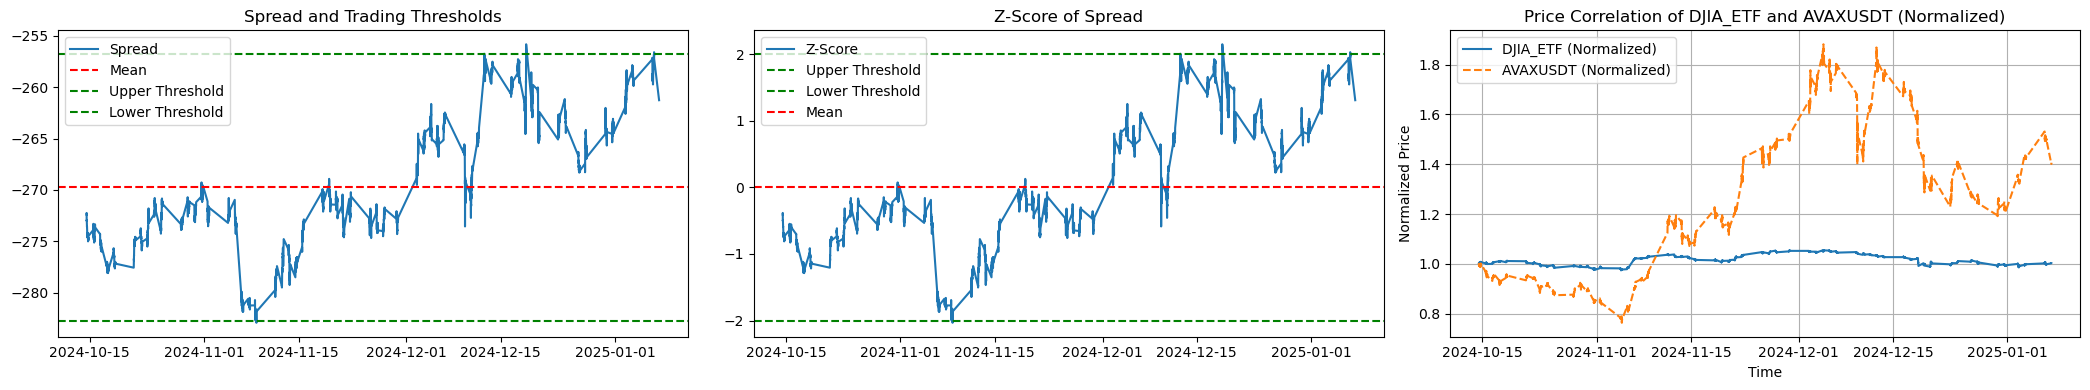

In [31]:
spread, adf_result, correlation = run_cointegration_test(price_pairs2, print_stats=True, plotting=True)

In [18]:
%%time
i = 0
list_results = []

for ticker_eqt in list_equity:
    for ticket_cpy in list_crypto:   
        i += 1
        
        # Prepare for pair prices
        price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)
        spread, adf_result, correlation = run_cointegration_test(price_pairs, print_stats=False, plotting=False)

        # Unpack adf_result for better readability
        adf_statistic, p_value, _, num_observations, *_ = adf_result

        # Check for stationarity
        spread_stationary = p_value <= 0.05

        # Store results
        list_results.append({
            "seriesX": ticker_eqt,
            "seriesY": ticket_cpy,
            "ADF_statistic": adf_statistic,
            "p-value": p_value,
            "correlation": correlation,
            "num_observations": num_observations,
            "spread_stationary": spread_stationary,
        })

print(f"# of Equity-Crypto Pairs: {i}")

# of Equity-Crypto Pairs: 170
CPU times: user 30.6 s, sys: 13.6 s, total: 44.2 s
Wall time: 13.8 s


In [19]:
df_results = pd.DataFrame(list_results)

In [20]:
df_results.spread_stationary.value_counts()

spread_stationary
False    145
True      25
Name: count, dtype: int64

In [21]:
df_results[df_results['spread_stationary']==True]

,seriesX,seriesY,ADF_statistic,p-value,correlation,num_observations,spread_stationary
8,NKY225_ETF,USDCUSDT,-3.174026,0.021538,0.099799,3847,True
18,AAPL,USDCUSDT,-3.552334,0.006740,0.383902,4448,True
28,AMZN,USDCUSDT,-3.273137,0.016123,-0.041807,4448,True
38,AVGO,USDCUSDT,-3.983643,0.001499,0.498658,4453,True
48,BRK.B,USDCUSDT,-4.089089,0.001010,-0.609681,4456,True
58,DJIA_ETF,USDCUSDT,-4.432004,0.000260,-0.671289,4456,True
68,GOOG,USDCUSDT,-3.338624,0.013238,0.160944,4449,True
78,GOOGL,USDCUSDT,-3.339922,0.013186,0.162879,4448,True
82,META,BNBUSDT,-3.338127,0.013258,0.786616,4448,True
87,META,TRXUSDT,-3.113414,0.025576,0.773627,4450,True


Pairs: BRK.B & USDCUSDT
Correlation: -0.610
ADF Statistic: -4.0891
p-value: 0.001 (Spread is stationary)


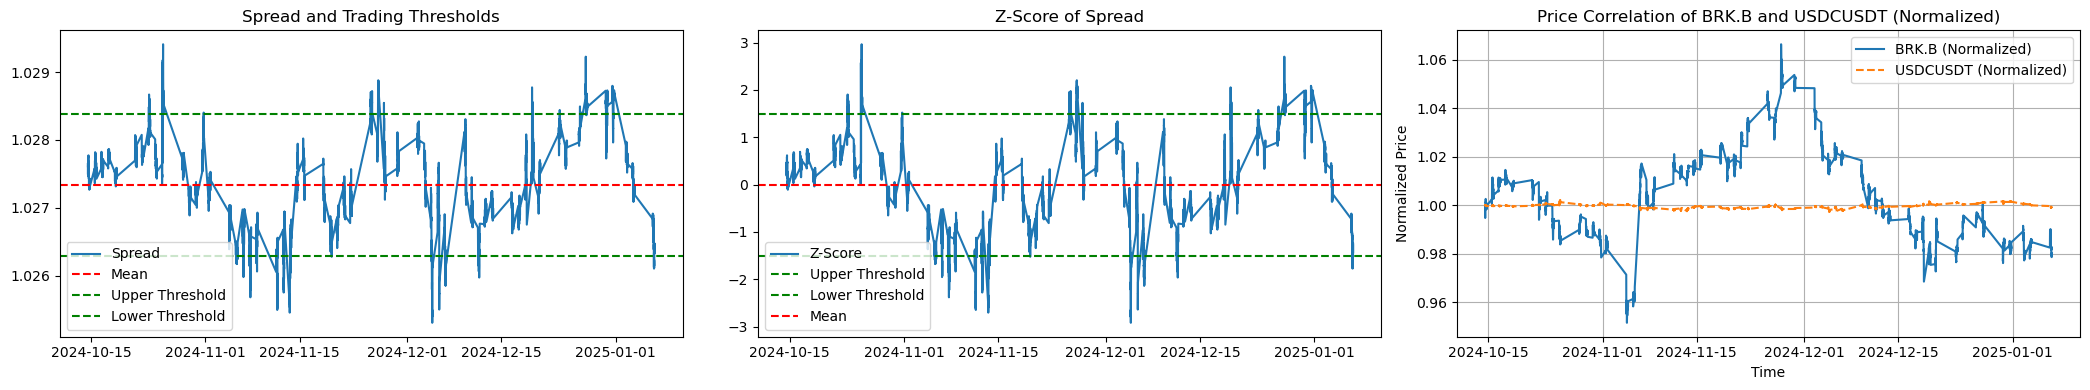

In [33]:
ticker_eqt = 'BRK.B'
ticket_cpy = 'USDCUSDT'
price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)
spread, adf_result, correlation = run_cointegration_test(price_pairs, print_stats=True, plotting=True, std=1.5)

Pairs: BRK.B & USDCUSDT
Correlation: -0.610
ADF Statistic: -4.0891
p-value: 0.001 (Spread is stationary)


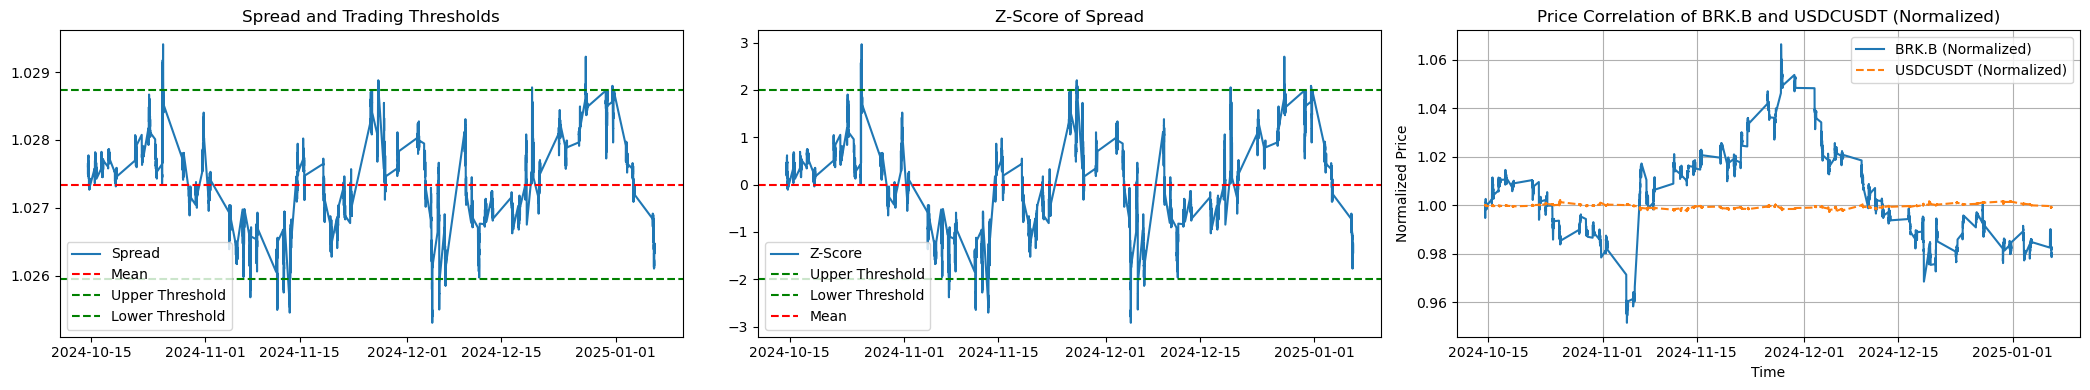

In [34]:
ticker_eqt = 'BRK.B'
ticket_cpy = 'USDCUSDT'
price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)
spread, adf_result, correlation = run_cointegration_test(price_pairs, print_stats=True, plotting=True, std=2)

Pairs: META & TRXUSDT
Correlation: 0.774
ADF Statistic: -3.1134
p-value: 0.026 (Spread is stationary)


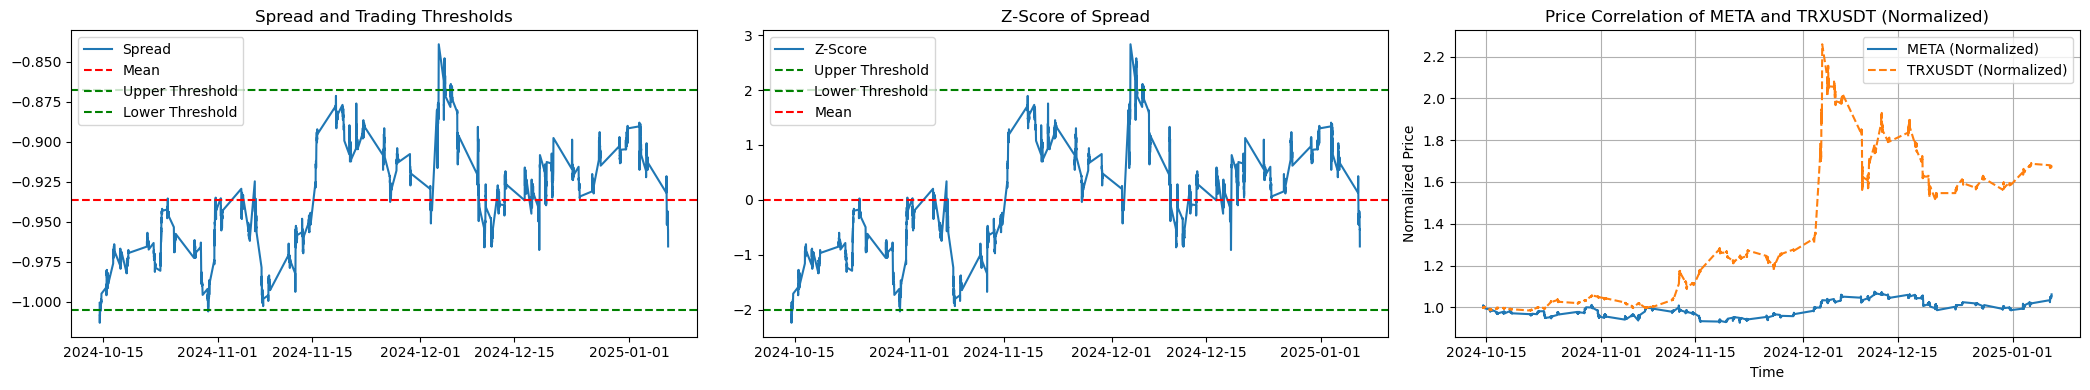

In [35]:
ticker_eqt = 'META'
ticket_cpy = 'TRXUSDT'
price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)
spread, adf_result, correlation = run_cointegration_test(price_pairs, print_stats=True, plotting=True)

Pairs: EQQQ_ETF & BNBUSDT
Correlation: 0.889
ADF Statistic: -4.2886
p-value: 0.000 (Spread is stationary)


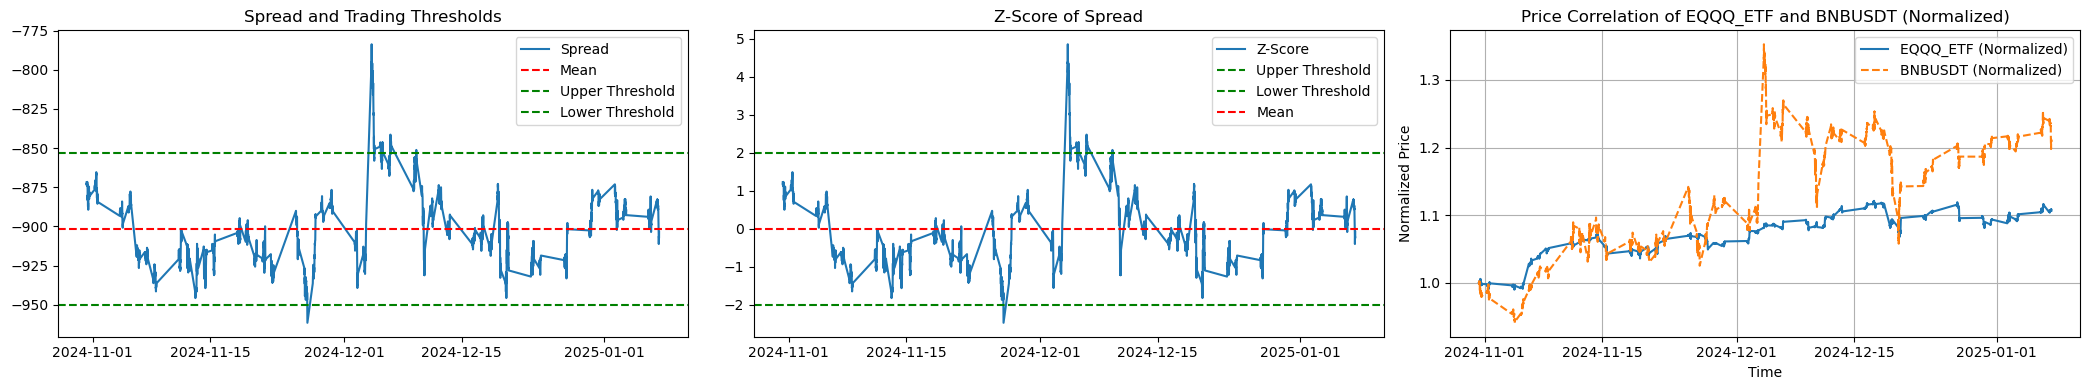

In [37]:
ticker_eqt = 'EQQQ_ETF'
ticket_cpy = 'BNBUSDT'
price_pairs = process_pairs_series(ticker_eqt, ticket_cpy, df_equity, df_crypto)

spread, adf_result, correlation = run_cointegration_test(price_pairs, print_stats=True, plotting=True)